In [1]:
import _pickle as cPickle
import numpy as np
import h5py
from operator import itemgetter
import copy
import random
from tqdm import tqdm
from collections import Counter, defaultdict

import sys
sys.path.append("../utils/")
import sequenceDatabaseObject as sdo
import utils as su

# Basic workflow

## 1. Basic k-fold partitioning

In [2]:
# Provide the path to the preprocessed objects from 0_preprocess_sequence_and_identities.ipynb

fasta_path = "../../1_Computing_Similarity/example_input/ex3.fa"
keys_to_idx_path = "../example_intermediate/ex3_key_to_idx.pickle"
hdf5_path = '../example_intermediate/ex3.h5'

seqdb = sdo.SeqDB(fasta_path, keys_to_idx_path, hdf5_path)

In [26]:
ts = 0.4
tc = 0.5

pos_keys = seqdb.get_positive_keys()
neg_keys = seqdb.get_negative_keys()

### Step 1. Split positives
pos_splits = su.get_positive_splits(pos_keys, seqdb)

### Step 2. Remove violations from positives
pos_splits_1 = su.remove_violations(pos_splits, seqdb, ts)

### Step 3. Split negatives without prior negative splits
neg_splits_1 = su.get_negative_splits_seeded(pos_splits_1, 
    dict(), # No prior negative splits
    seqdb, 
    ts, 
    neg_keys, 
    tc, 
    check_violations_at_the_end=True    # If no prior negative splits, check violations at the end
    )

Adding Back Sequences: 100%|██████████| 148/148 [00:00<00:00, 189.39it/s]


### 1.1. Partitioning negatives with a prior set of negative

In [27]:
ts = 0.4
tc = 0.4

### Step 3. Split negatives without prior negative splits
neg_splits_2 = su.get_negative_splits_seeded(pos_splits_1, 
    neg_splits_1, # With prior negative splits
    seqdb, 
    ts, 
    neg_keys, 
    tc, 
    check_violations_at_the_end=False    # If no prior negative splits, check violations at the end
    )

## 2. Dataset construction strategy

### 2.1. No Balance

In [28]:
print("\nPositive split sizes:")
for k, v in pos_splits_1.items():
    print(k, len(v))
print()

print("\nNegative split sizes:")
for k, v in neg_splits_2.items():
    print(k, len(v))
print()



Positive split sizes:
Pr_WHOIUIS_1001_1442_0 149
Pr_WHOIUIS_1005_1445_1 146
Pr_WHOIUIS_1008_1449_0 146


Negative split sizes:
Pr_WHOIUIS_1001_1442_0 99
Pr_WHOIUIS_1005_1445_1 219
Pr_WHOIUIS_1008_1449_0 223



### 2.2. Hard Balance

In [29]:
neg_splits_balanced = su.get_balance(pos_splits_1, neg_splits_2)

In [30]:
print("\nPositive split sizes:")
for k, v in pos_splits_1.items():
    print(k, len(v))
print()

print("\nNegative split sizes:")
for k, v in neg_splits_balanced.items():
    print(k, len(v))
print()



Positive split sizes:
Pr_WHOIUIS_1001_1442_0 149
Pr_WHOIUIS_1005_1445_1 146
Pr_WHOIUIS_1008_1449_0 146


Negative split sizes:
Pr_WHOIUIS_1001_1442_0 99
Pr_WHOIUIS_1005_1445_1 146
Pr_WHOIUIS_1008_1449_0 146



### 2.3. Length Control

In [31]:
neg_splits_lenth_control = su.get_length_control(pos_splits_1, neg_splits_2, seqdb)

In [32]:
print("\nPositive split sizes:")
for k, v in pos_splits_1.items():
    print(k, len(v))
print()

print("\nNegative split sizes:")
for k, v in neg_splits_lenth_control.items():
    print(k, len(v))
print()



Positive split sizes:
Pr_WHOIUIS_1001_1442_0 149
Pr_WHOIUIS_1005_1445_1 146
Pr_WHOIUIS_1008_1449_0 146


Negative split sizes:
Pr_WHOIUIS_1001_1442_0 99
Pr_WHOIUIS_1005_1445_1 146
Pr_WHOIUIS_1008_1449_0 146



### 2.4. Minimal

In [35]:
pos_splits_minimal, neg_splits_minimal = su.get_minimal(pos_splits_1, neg_splits_2, seqdb, min_pos=50, min_neg=50, tc=tc)

In [36]:
print("\nPositive split sizes:")
for k, v in pos_splits_minimal.items():
    print(k, len(v))
print()

print("\nNegative split sizes:")
for k, v in neg_splits_minimal.items():
    print(k, len(v))
print()



Positive split sizes:
Pr_WHOIUIS_1001_1442_0 50
Pr_WHOIUIS_1005_1445_1 50
Pr_WHOIUIS_1008_1449_0 50


Negative split sizes:
Pr_WHOIUIS_1001_1442_0 50
Pr_WHOIUIS_1005_1445_1 50
Pr_WHOIUIS_1008_1449_0 50



# Inspect splits

In [37]:
import matplotlib.pyplot as plt

## Check inter-split identities between positive splits

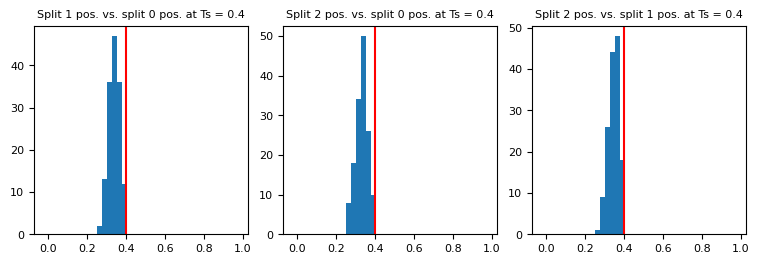

In [40]:
split_keys = sorted(list(pos_splits_1.keys()))

fig, ax = plt.subplots(1, len(split_keys), sharex=True, figsize=(7.5, 2.5))

n = 0
for n_split_key1, split_key1 in enumerate(split_keys):
    seqs1 = sorted(list(pos_splits_1[split_key1]))
    for n_split_key2, split_key2 in enumerate(split_keys[:n_split_key1]):
        seqs2 = sorted(list(pos_splits_1[split_key2]))
        idents = seqdb.get_ident(seqs1, seqs2)

        max_idents = np.max(idents, axis = 1)
        
        binsize = 0.025
        counts, bins = np.histogram(max_idents, bins=np.arange(-0.01, 1.01, binsize))
        ax[n].bar(bins[:-1], counts, width=binsize)
        ax[n].axvline(0.4, color='red')
        ax[n].set_title("Split {:} pos. vs. split {:} pos. at Ts = 0.4".format(n_split_key1, n_split_key2), fontsize=8)
        ax[n].tick_params(axis="both", labelsize=8)
        n += 1
fig.tight_layout(pad=0.2)
plt.show()

## Check inter-split identities between negative splits at Ts=0.4

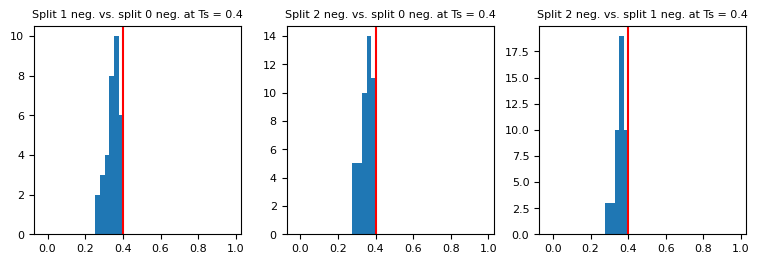

In [41]:
split_keys = sorted(list(neg_splits_1.keys()))

fig, ax = plt.subplots(1, len(split_keys), sharex=True, figsize=(7.5, 2.5))

n = 0
for n_split_key1, split_key1 in enumerate(split_keys):
    seqs1 = sorted(list(neg_splits_1[split_key1]))
    for n_split_key2, split_key2 in enumerate(split_keys[:n_split_key1]):
        seqs2 = sorted(list(neg_splits_1[split_key2]))
        idents = seqdb.get_ident(seqs1, seqs2)

        max_idents = np.max(idents, axis = 1)
        
        binsize = 0.025
        counts, bins = np.histogram(max_idents, bins=np.arange(-0.01, 1.01, binsize))
        ax[n].bar(bins[:-1], counts, width=binsize)
        ax[n].axvline(0.4, color='red')
        ax[n].set_title("Split {:} neg. vs. split {:} neg. at Ts = 0.4".format(n_split_key1, n_split_key2), fontsize=8)
        ax[n].tick_params(axis="both", labelsize=8)
        n += 1
fig.tight_layout(pad=0.2)
plt.show()

## Check inter-class identites in each split

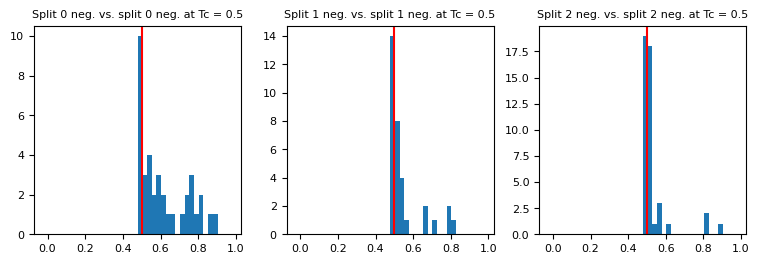

In [42]:
split_keys = sorted(list(pos_splits_1.keys()))

fig, ax = plt.subplots(1, len(split_keys), sharex=True, figsize=(7.5, 2.5))

for n_split_key1, split_key1 in enumerate(split_keys):
    seqs1 = sorted(list(neg_splits_1[split_key1]))
    seqs2 = sorted(list(pos_splits_1[split_key1]))
    idents = seqdb.get_ident(seqs1, seqs2)

    max_idents = np.max(idents, axis = 1)
    
    binsize = 0.025
    counts, bins = np.histogram(max_idents, bins=np.arange(-0.01, 1.01, binsize))
    ax[n_split_key1].bar(bins[:-1], counts, width=binsize)
    ax[n_split_key1].axvline(0.5, color='red')
    ax[n_split_key1].set_title("Split {:} neg. vs. split {:} neg. at Tc = 0.5".format(n_split_key1, n_split_key1), fontsize=8)
    ax[n_split_key1].tick_params(axis="both", labelsize=8)
fig.tight_layout(pad=0.2)
plt.show()

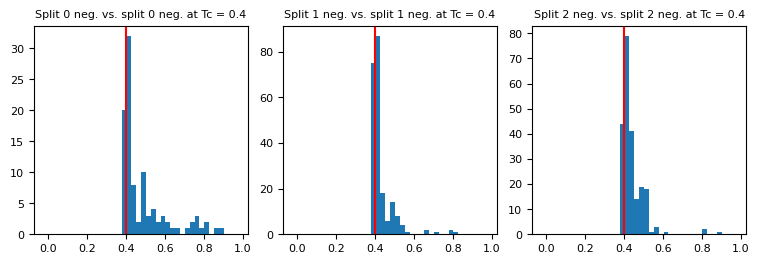

In [43]:
split_keys = sorted(list(pos_splits_1.keys()))

fig, ax = plt.subplots(1, len(split_keys), sharex=True, figsize=(7.5, 2.5))

for n_split_key1, split_key1 in enumerate(split_keys):
    seqs1 = sorted(list(neg_splits_2[split_key1]))
    seqs2 = sorted(list(pos_splits_1[split_key1]))
    idents = seqdb.get_ident(seqs1, seqs2)

    max_idents = np.max(idents, axis = 1)
    
    binsize = 0.025
    counts, bins = np.histogram(max_idents, bins=np.arange(-0.01, 1.01, binsize))
    ax[n_split_key1].bar(bins[:-1], counts, width=binsize)
    ax[n_split_key1].axvline(0.4, color='red')
    ax[n_split_key1].set_title("Split {:} neg. vs. split {:} neg. at Tc = 0.4".format(n_split_key1, n_split_key1), fontsize=8)
    ax[n_split_key1].tick_params(axis="both", labelsize=8)
fig.tight_layout(pad=0.2)
plt.show()